In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import scipy
import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from plotly.subplots import make_subplots
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency, ttest_ind
from sklearn import set_config
set_config(transform_output="pandas")

In [47]:
import os
os.chdir('C:/users/15199/DSI/rk_team_project')

In [48]:
# Reading the dataset
file_path = 'Stroke/stroke_full.csv'
df = pd.read_csv(file_path)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender_encoded,ever_married_encoded,work_type_encoded,Residence_type_encoded,smoking_status_encoded,Age_temp,avg_glucose_level_temp
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,1,1,2,1,1,1,2
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.8,never smoked,1,0,1,3,0,2,1,2
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,1,1,2,0,2,1,2
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,0,1,2,1,3,0,2
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,0,1,3,0,2,1,2


In [49]:
df['heart_risk'] = (df['hypertension'] | df['heart_disease']).astype(int)

In [50]:
# categorical = ['gender', 'ever_married', 'work_type', 
#                'Residence_type', 'smoking_status', 'hypertension', 
#                'heart_disease', 'stroke']
# numerical = ['age', 'avg_glucose_level', 'bmi']

In [51]:
categorical = ['gender', 'ever_married', 'work_type', 
               'Residence_type', 'smoking_status', 'heart_risk', 'stroke']
numerical = ['age', 'avg_glucose_level', 'bmi']

In [52]:
# Initialize an empty dictionary to store the chi-square test results
results = {}

# Loop through each categorical variable in the dataset
for var in categorical:
    # Create a contingency table between the categorical variable and the target variable ("stroke")
    contingency_table = pd.crosstab(df[var], df["stroke"])
    
    # Perform the chi-square test of independence
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Store the test results in the dictionary
    results[var] = {
        "Chi2": chi2,              # Chi-square test statistic
        "p-value": p,              # p-value of the test
        "Association": "Yes" if p <= 0.05 else "No"  # Determine statistical significance (α = 0.05)
    }

# Convert the dictionary to a DataFrame for better readability
chi_square_results = pd.DataFrame(results).T

# Display the results
print(chi_square_results)


                       Chi2   p-value Association
gender             0.917759  0.338064          No
ever_married       0.004196   0.94835          No
work_type          3.998458   0.13544          No
Residence_type     1.223736  0.268629          No
smoking_status     5.011184   0.17098          No
heart_risk        67.275293       0.0         Yes
stroke          3398.120423       0.0         Yes


Chi-Square test of Independence measures if there is a significant relationship between two categorical variables. It measures how a model compares to actual observed data. 

Interpret the p-value:  

If p <= 0.05, reject the null hypothesis (There is no relationship) (i.e., the variables are associated).  

If p > 0.05, fail to reject the null hypothesis (There is relationship) (i.e., no significant association).

The results above indicate that **stroke** has no relationship with **gender**, **ever_married**, **work_type**, **residence type**, and **smoking status**. So, we can remove these predictors from the model building. 

Standardizing numerical variables to use them to run the t-test.

In [53]:
# Standardizing only numerical variables
df[numerical] = StandardScaler().fit_transform(df[numerical])
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender_encoded,ever_married_encoded,work_type_encoded,Residence_type_encoded,smoking_status_encoded,Age_temp,avg_glucose_level_temp,heart_risk
0,Male,0.763532,0,1,Yes,Private,Urban,2.312038,0.887420,formerly smoked,1,1,1,2,1,1,1,2,1
1,Female,0.343728,0,0,Yes,Self-employed,Rural,1.787070,-0.305926,never smoked,1,0,1,3,0,2,1,2,0
2,Male,1.673108,0,1,Yes,Private,Rural,-0.121883,0.260149,never smoked,1,1,1,2,0,2,1,2,1
3,Female,-0.495881,0,0,Yes,Private,Urban,1.172891,0.550835,smokes,1,0,1,2,1,3,0,2,0
4,Female,1.603141,1,0,Yes,Self-employed,Rural,1.230185,-1.040292,never smoked,1,0,1,3,0,2,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,Female,1.673108,1,0,Yes,Private,Urban,-0.561404,-0.367123,never smoked,0,0,1,2,1,2,1,1,1
3409,Female,1.743076,0,0,Yes,Self-employed,Urban,0.260344,1.407596,never smoked,0,0,1,3,1,2,1,2,0
3410,Female,-1.475424,0,0,Yes,Self-employed,Rural,-0.576471,-0.030538,never smoked,0,0,1,3,0,2,0,1,0
3411,Male,-0.355946,0,0,Yes,Private,Rural,1.074955,-0.795503,formerly smoked,0,1,1,2,0,1,0,2,0


In [54]:
numerical = list(df[numerical].columns)

# T-Test for each numerical variable
results = {}
for var in numerical:
    group1 = df[df["stroke"] == 0][var]  # No Stroke
    group2 = df[df["stroke"] == 1][var]  # Stroke
    
    # Perform an independent T-test to compare the means of the two groups
    t_stat, p_value = ttest_ind(group1, group2)
    
    # Store the test results in the dictionary
    results[var] = {"T-Statistic": t_stat, "p-value": p_value, "Significant": "Yes" if p_value <= 0.05 else "No"}

# Convert results to DataFrame
t_test_results = pd.DataFrame(results).T
print(t_test_results)

                  T-Statistic p-value Significant
age                 -14.24772     0.0         Yes
avg_glucose_level   -6.848022     0.0         Yes
bmi                  1.186519  0.2355          No


T-test compares the means of the numerical predictor between the two categories. In our case we are checking if age differs significantly between stroke vs. no stroke.  

The results show that **age**, and **average glucose level** are significantly different between stroke and non-stroke patients. However, there is no significant difference in means of **bmi** between No stroke and Stroke patients. So, we'll drop bmi.

In [55]:
df = df[['age', 'avg_glucose_level', 'heart_risk', 'stroke']]
df.head(3)

,age,avg_glucose_level,heart_risk,stroke
0,0.763532,2.312038,1,1
1,0.343728,1.787070,0,1
2,1.673108,-0.121883,1,1


In [56]:
df = df[['age', 'avg_glucose_level', 'heart_risk', 'stroke']]
df.head(3)
df.to_csv('stroke_dataset_for_modeling.csv', index=False)

## Logistic Regression to predict Stroke

In [57]:
# Splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df['stroke'], test_size=0.20, random_state=42)

## Class Imbalance

The classification report is: 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        60

   micro avg       0.00      0.00      0.00        60
   macro avg       0.00      0.00      0.00        60
weighted avg       0.00      0.00      0.00        60


ROC AUC Score: 0.7963


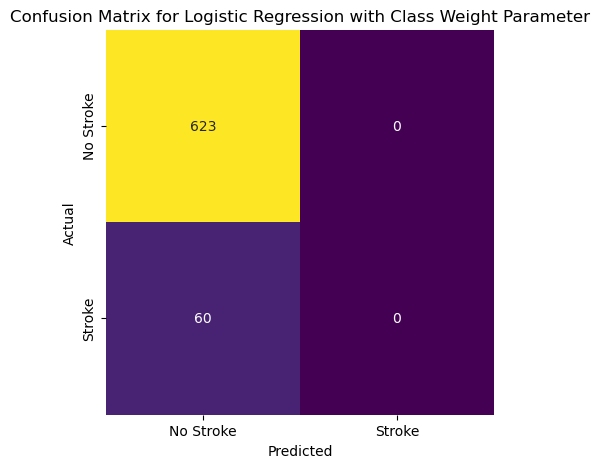

In [58]:
log_reg = LogisticRegression(random_state=42)

# Fit the model
log_reg.fit(x_train, y_train)

# Predict on the test set
y_pred_log_reg = log_reg.predict(x_test)

# Evaluate the model by focusing on 'label = 1' (positive class)
report_log_reg = classification_report(y_test, y_pred_log_reg, labels = [1])
print(f"The classification report is: \n {report_log_reg}\n")

conf_matrix = confusion_matrix(y_test, y_pred_log_reg)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(x_test)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

f1_m1 = f1_score(y_test, y_pred_log_reg)

plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression with Class Weight Parameter')
plt.show()

## Handling Class Imbalance using class_weight parameter

The classification report is: 
               precision    recall  f1-score   support

           1       0.18      0.75      0.29        60

   micro avg       0.18      0.75      0.29        60
   macro avg       0.18      0.75      0.29        60
weighted avg       0.18      0.75      0.29        60


ROC AUC Score: 0.7967


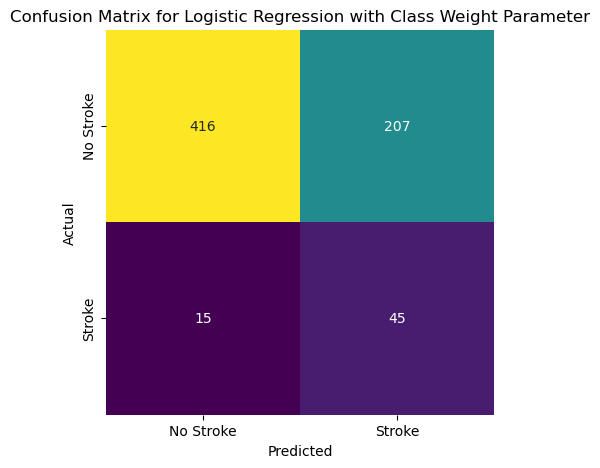

In [59]:
log_reg = LogisticRegression(class_weight='balanced', random_state=42)

# Fit the model
log_reg.fit(x_train, y_train)

# Predict on the test set
y_pred_log_reg = log_reg.predict(x_test)

# Evaluate the model by focusing on 'label = 1' (positive class)
report_log_reg = classification_report(y_test, y_pred_log_reg, labels = [1])
print(f"The classification report is: \n {report_log_reg}\n")

conf_matrix = confusion_matrix(y_test, y_pred_log_reg)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(x_test)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

f1_m2 = f1_score(y_test, y_pred_log_reg)

plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression with Class Weight Parameter')
plt.show()

## Hyperparameter Tuning

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters: {'class_weight': {0: 1, 1: 5}, 'max_iter': 100}
The classification report is: 
              precision    recall  f1-score   support

           1       0.31      0.45      0.37        60

   micro avg       0.31      0.45      0.37        60
   macro avg       0.31      0.45      0.37        60
weighted avg       0.31      0.45      0.37        60

ROC AUC Score: 0.7964


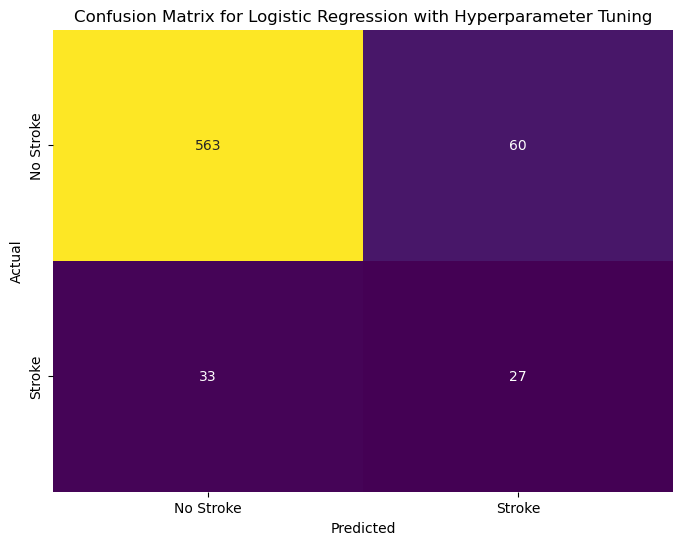

In [60]:
log_reg = LogisticRegression(random_state=42)

# Define the parameter grid for class_weight and max_iter
param_grid = {
    'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 50}, {0: 1, 1: 100}, {0: 1, 1: 500}, {0: 1, 1: 1000}],
    'max_iter': [100, 200, 500, 1000]  # Range of max_iter values
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the GridSearchCV
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

# Get the best model from GridSearchCV
best_log_reg = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred_log_reg = best_log_reg.predict(x_test)

# Evaluate the model using classification report
report_log_reg = classification_report(y_test, y_pred_log_reg, labels=[1])
print(f"The classification report is: \n{report_log_reg}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_log_reg)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, best_log_reg.predict_proba(x_test)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

f1_m3 = f1_score(y_test, y_pred_log_reg)

# Plot confusion matrix using seaborn heatmap
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, 
            xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'], ax=ax)

# Customize labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression with Hyperparameter Tuning')

# Show the plot
plt.show()

## SMOTE

Before SMOTE:

stroke
0    2543
1     187
Name: count, dtype: int64

After SMOTE:

stroke
0    2543
1    2543
Name: count, dtype: int64

The classification report is: 
               precision    recall  f1-score   support

           1       0.19      0.80      0.31        60

   micro avg       0.19      0.80      0.31        60
   macro avg       0.19      0.80      0.31        60
weighted avg       0.19      0.80      0.31        60


ROC AUC Score: 0.7959


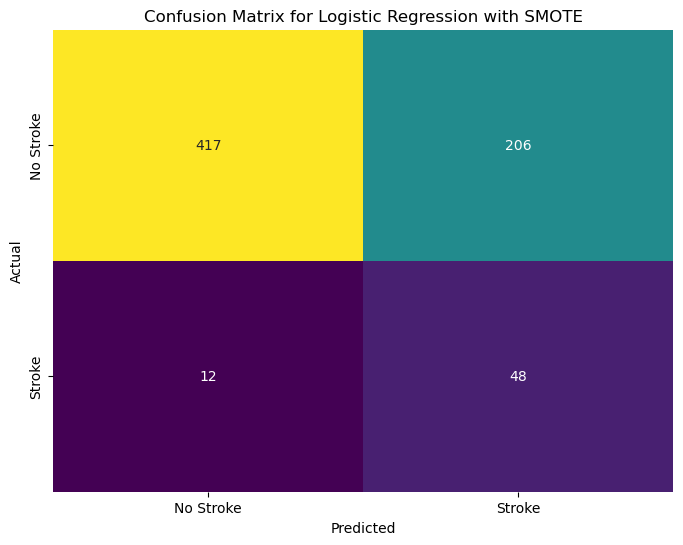

In [61]:
smote = SMOTE(random_state=42)

x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Check the new class distribution after SMOTE
print("Before SMOTE:\n")
print(f"{y_train.value_counts()}\n")
print("After SMOTE:\n")
print(f"{y_train_smote.value_counts()}\n")

# Instantiate the Logistic Regression model
log_reg = LogisticRegression(random_state=42)

# Fit the model using the SMOTE-resampled training data
log_reg.fit(x_train_smote, y_train_smote)

# Predict on the test set
y_pred_log_reg = log_reg.predict(x_test)

# Evaluate the model by focusing on 'label = 1' (positive class)
report_log_reg = classification_report(y_test, y_pred_log_reg, labels = [1])
print(f"The classification report is: \n {report_log_reg}\n")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_log_reg)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(x_test)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

f1_m4 = f1_score(y_test, y_pred_log_reg)

# Plot confusion matrix using seaborn heatmap
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'], ax=ax)

# Customize labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression with SMOTE')

# Show the plot
plt.show()

## SMOTE + Hyperparameter Tuning

Before SMOTE:
 stroke
0    2543
1     187
Name: count, dtype: int64

After SMOTE:
 stroke
0    2543
1    2543
Name: count, dtype: int64
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'class_weight': {0: 1, 1: 5}, 'max_iter': 100}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.17      0.29       623
           1       0.10      1.00      0.19        60

    accuracy                           0.24       683
   macro avg       0.55      0.59      0.24       683
weighted avg       0.92      0.24      0.28       683

ROC AUC Score: 0.7957


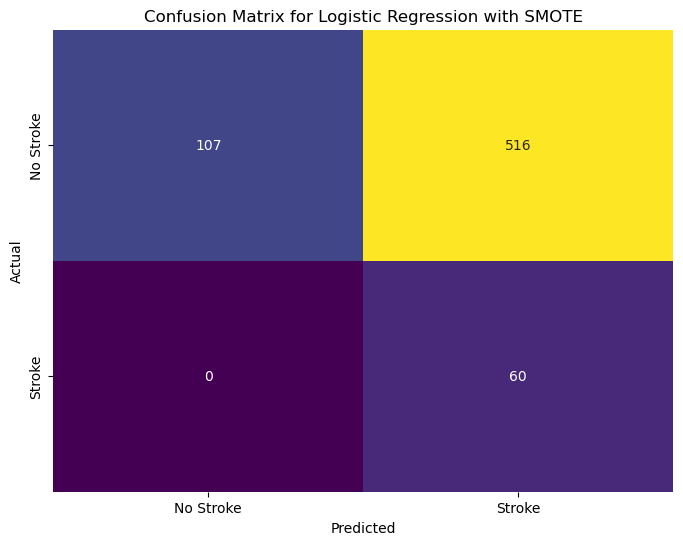

In [62]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Check new class distribution after SMOTE
print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", y_train_smote.value_counts())

# Define custom hyperparameter grid
param_grid = {
    'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 50}, {0: 1, 1: 100}, {0: 1, 1: 500}, {0: 1, 1: 1000}],
    'max_iter': [100, 200, 500, 1000]  # Range of max_iter values
}

# Initialize Logistic Regression model
log_reg = LogisticRegression(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(x_train_smote, y_train_smote)

# Get the best model and hyperparameters
best_log_reg = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Predict on test data
y_pred_log_reg = best_log_reg.predict(x_test)

# Evaluation Metrics
report_log_reg = classification_report(y_test, y_pred_log_reg)
print(f"Classification Report:\n{report_log_reg}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_log_reg)
roc_auc = roc_auc_score(y_test, best_log_reg.predict_proba(x_test)[:, 1])

print(f"ROC AUC Score: {roc_auc:.4f}")

f1_m5 = f1_score(y_test, y_pred_log_reg)

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, 
            xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression with SMOTE')
plt.show()


## Decision Tree With Class Weight

Classification Report:
              precision    recall  f1-score   support

           1       0.16      0.12      0.13        60

   micro avg       0.16      0.12      0.13        60
   macro avg       0.16      0.12      0.13        60
weighted avg       0.16      0.12      0.13        60

ROC AUC Score: 0.5286


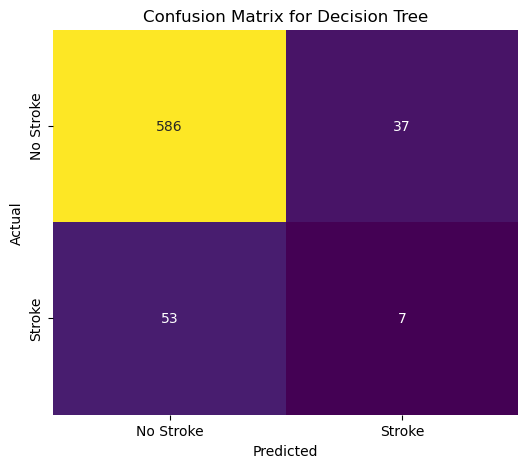

In [63]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Fit the Decision Tree model on the training data
dt.fit(x_train, y_train)

# Predict on the test set
y_pred_dt = dt.predict(x_test)

# Evaluate the model using classification report
report_dt = classification_report(y_test, y_pred_dt, labels=[1])
print(f"Classification Report:\n{report_dt}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, dt.predict_proba(x_test)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

f1_m6 = f1_score(y_test, y_pred_dt)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, 
            xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# Hyperparameter Tuning - Decision Tree

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.65      0.78       623
           1       0.18      0.80      0.29        60

    accuracy                           0.66       683
   macro avg       0.58      0.73      0.54       683
weighted avg       0.90      0.66      0.74       683

ROC AUC Score: 0.7419


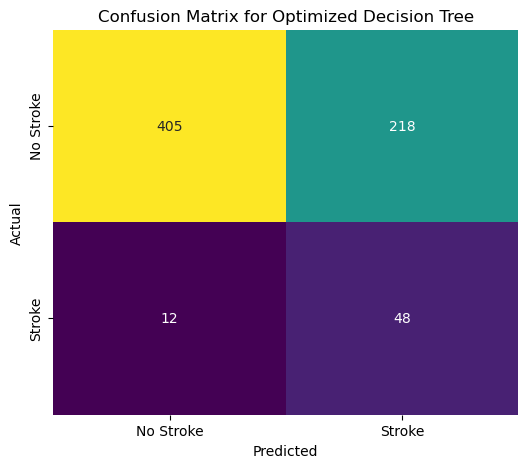

In [64]:
# Define hyperparameters to tune
param_grid = {
    "max_depth": [3, 5, 10, 20, 30, None],  # More depth options
    "min_samples_split": [2, 5, 10, 20, 50],  # More values for splitting
    "min_samples_leaf": [1, 2, 5, 10, 20],  # More options for minimum samples per leaf
    "criterion": ["gini", "entropy", "log_loss"],  # Adding log_loss for impurity measure
    "max_features": ["sqrt", "log2", None]  # Controls the number of features to consider
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Grid Search with Cross-Validation (5-fold)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(x_train, y_train)

# Get the best model
best_dt = grid_search.best_estimator_

# Print the best parameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Predict on the test set using the best model
y_pred_dt = best_dt.predict(x_test)

# Evaluate the model using classification report
report_dt = classification_report(y_test, y_pred_dt)
print(f"Classification Report:\n{report_dt}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt)

# Compute ROC AUC Score
roc_auc = roc_auc_score(y_test, best_dt.predict_proba(x_test)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

f1_m7 = f1_score(y_test, y_pred_dt)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, 
            xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Optimized Decision Tree')
plt.show()


## SMOTE + Hyperparameter Tuning

Before SMOTE:
, stroke
0    2543
1     187
Name: count, dtype: int64


After SMOTE:
, stroke
0    2543
1    2543
Name: count, dtype: int64

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       623
           1       0.14      0.18      0.16        60

    accuracy                           0.83       683
   macro avg       0.53      0.54      0.53       683
weighted avg       0.85      0.83      0.84       683

ROC AUC Score: 0.6438


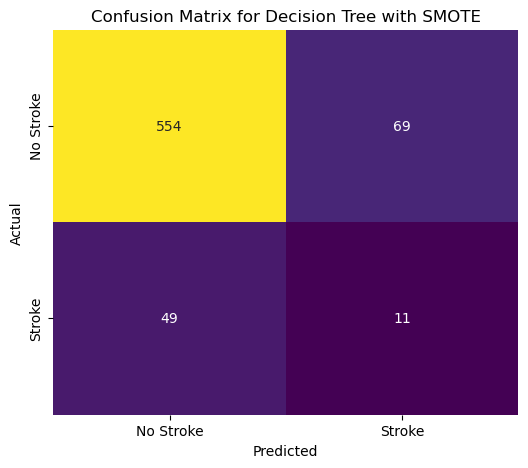

In [65]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Check new class distribution after SMOTE
print(f"Before SMOTE:\n, {y_train.value_counts()}\n")
print(f"\nAfter SMOTE:\n, {y_train_smote.value_counts()}\n")

# Define hyperparameter grid (wide range)
param_grid = {
    "max_depth": [3, 5, 10, 20, 30, None],  
    "min_samples_split": [2, 5, 10, 20, 50],  
    "min_samples_leaf": [1, 2, 5, 10, 20],  
    "criterion": ["gini", "entropy", "log_loss"],  
    "max_features": ["sqrt", "log2", None]  
}

# Initialize Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(x_train_smote, y_train_smote)

# Get the best model and hyperparameters
best_dt = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Predict on test data
y_pred_dt = best_dt.predict(x_test)

# Evaluation Metrics
report_dt = classification_report(y_test, y_pred_dt)
print(f"Classification Report:\n{report_dt}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt)
roc_auc = roc_auc_score(y_test, best_dt.predict_proba(x_test)[:, 1])

print(f"ROC AUC Score: {roc_auc:.4f}")

f1_m8 = f1_score(y_test, y_pred_dt)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, 
            xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree with SMOTE')
plt.show()


## Random Forest with class weight

Classification Report:
              precision    recall  f1-score   support

           1       0.12      0.03      0.05        60

   micro avg       0.12      0.03      0.05        60
   macro avg       0.12      0.03      0.05        60
weighted avg       0.12      0.03      0.05        60

ROC AUC Score: 0.6657


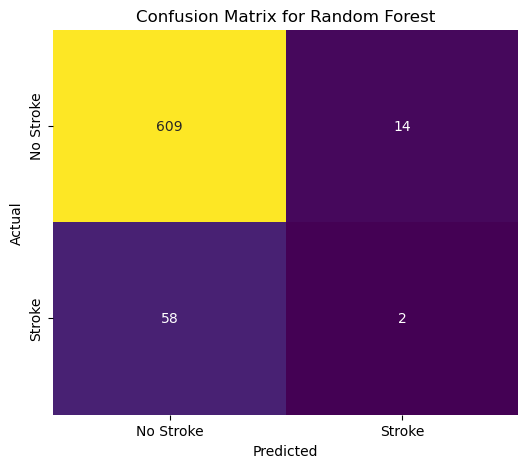

In [66]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(x_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(x_test)

# Evaluate the model
report_rf = classification_report(y_test, y_pred_rf, labels=[1])
print(f"Classification Report:\n{report_rf}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, rf.predict_proba(x_test)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

f1_m9 = f1_score(y_test, y_pred_rf)


# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

## Random Forest with SMOTE

Before SMOTE:
stroke
0    2543
1     187
Name: count, dtype: int64

After SMOTE:
stroke
0    2543
1    2543
Name: count, dtype: int64



Classification Report:
               precision    recall  f1-score   support

           1       0.16      0.27      0.20        60

   micro avg       0.16      0.27      0.20        60
   macro avg       0.16      0.27      0.20        60
weighted avg       0.16      0.27      0.20        60

ROC AUC Score: 0.6603


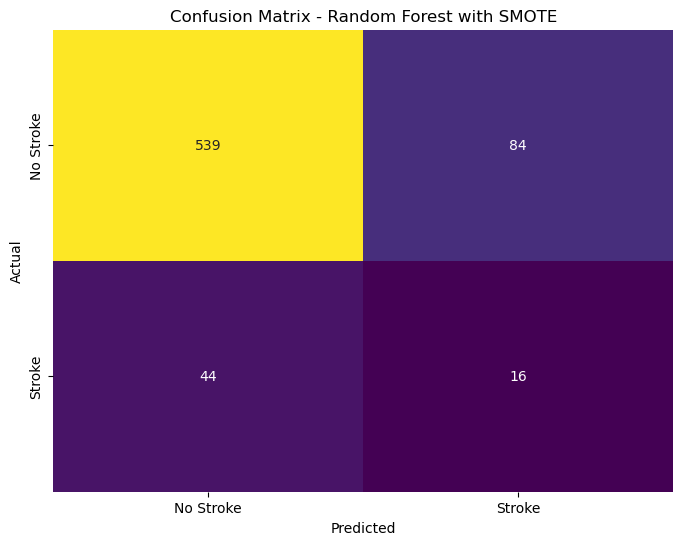

In [67]:
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Check class distribution before and after SMOTE
print(f"Before SMOTE:\n{y_train.value_counts()}\n")
print(f"After SMOTE:\n{y_train_smote.value_counts()}\n")

# Train Random Forest on SMOTE-resampled data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(x_train_smote, y_train_smote)

# Predict on the test set
y_pred_rf = rf_model.predict(x_test)

# Classification report focusing on label 1
print("Classification Report:\n", classification_report(y_test, y_pred_rf, labels=[1]))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(x_test)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

f1_m10 = f1_score(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, 
            xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest with SMOTE')

# Show the plot
plt.show()

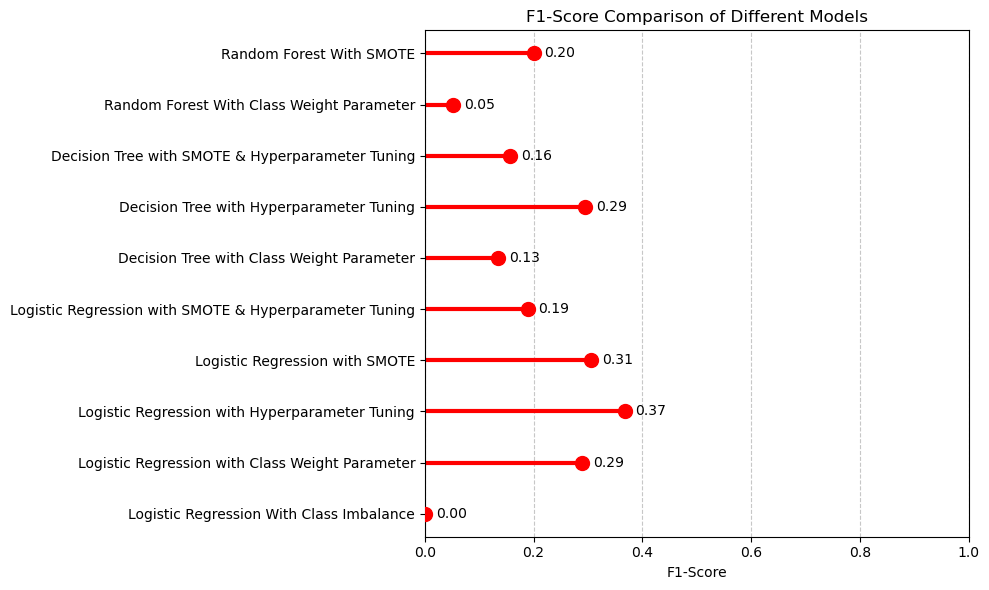

In [ ]:
models = ['Logistic Regression With Class Imbalance', 
          'Logistic Regression with Class Weight Parameter', 
          'Logistic Regression with Hyperparameter Tuning', 
          'Logistic Regression with SMOTE', 
          'Logistic Regression with SMOTE & Hyperparameter Tuning', 
          'Decision Tree with Class Weight Parameter', 
          'Decision Tree with Hyperparameter Tuning', 
          'Decision Tree with SMOTE & Hyperparameter Tuning', 
          'Random Forest With Class Weight Parameter', 
          'Random Forest With SMOTE']

f1_scores = [f1_m1, f1_m2, f1_m3, f1_m4, f1_m5, f1_m6, f1_m7, f1_m8, f1_m9, f1_m10]

plt.figure(figsize=(10, 6))

# Plot the horizontal lines (lollipop sticks)
plt.hlines(np.arange(len(f1_scores)), 0, f1_scores, color='red', lw=3)

# Plot the lollipop heads (dots)
plt.scatter(f1_scores, np.arange(len(f1_scores)), color='red', s=100, zorder=5)

# Customize the plot
plt.yticks(np.arange(len(f1_scores)), models)  # Set the y-axis labels to model names
plt.xlim(0, 1)  # Set x-axis range from 0 to 1 for F1-score
plt.xlabel('F1-Score')  # Label for the x-axis
plt.title('F1-Score Comparison of Different Models')

# Rotate y-axis labels for better readability
plt.yticks(rotation=0)

# Add grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add the F1-score value next to each lollipop head
for i, score in enumerate(f1_scores):
    plt.text(score + 0.02, i, f'{score:.2f}', va='center', ha='left', fontsize=10)

# Use tight layout to ensure labels fit well
plt.tight_layout()

# Show the plot
plt.show()
